# Vision Transformer (ViT)

inspired by this [notebook](https://www.kaggle.com/raufmomin/vision-transformer-vit-fine-tuning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os
from pathlib import Path

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping

from tensorflow.keras.utils import Sequence
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from vit_keras import vit, utils
from vit_keras import visualize

from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# sys.path.append('../')
import leukopy_lib as leuko
from importlib import reload

reload(leuko)

<module 'leukopy_lib' from '/kaggle/usr/lib/leukopy_lib/leukopy_lib.py'>

# Set up

## Generate dataframes

In [3]:
# pa/kaggle/ = Path('main_dataset/')
INPUT_PATH = Path('../input/main-dataset/main_dataset/')

df_train = leuko.generate_images_df(INPUT_PATH/'training_set')
df_test = leuko.generate_images_df(INPUT_PATH/'testing_set')
df_valid = leuko.generate_images_df(INPUT_PATH/'validation_set')

df_train.head()

,img_path,cell_type,label,label_2,label_3
0,../input/main-dataset/main_dataset/training_se...,training_set,BA,BA,BA
1,../input/main-dataset/main_dataset/training_se...,training_set,BNE,IG,BNE
2,../input/main-dataset/main_dataset/training_se...,training_set,MO,MO,MO
3,../input/main-dataset/main_dataset/training_se...,training_set,MY,IG,IG
4,../input/main-dataset/main_dataset/training_se...,training_set,BA,BA,BA


### choose classes

In [4]:
N_CLASSES, df_train, df_test, df_valid = leuko.choose_classes(df_train, df_test, df_valid, n_classes = 11)

In [5]:
N_CLASSES

11

In [6]:
df_train["label"].value_counts()

EO     2349
PLT    1739
SNE    1263
BNE    1212
ERB    1162
MO     1068
LY      944
BA      903
MY      833
MMY     734
PMY     460
Name: label, dtype: int64

## Image generator

For ViT image are patched into [16x16](https://arxiv.org/abs/2010.11929) images ("images is worth 16x16 words")

In [7]:
BATCH_SIZE = 32
IMG_SIZE  = 224 #need to be a multiple of patch size = 16
EPOCHS = 100
LR = 1e-4

In [8]:
train_generator = ImageDataGenerator(rotation_range = 90,
                                     horizontal_flip = True, 
                                     vertical_flip = True)
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # uses x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (IMG_SIZE, IMG_SIZE), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # uses y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = True)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # uses x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (IMG_SIZE, IMG_SIZE), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # uses y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = BATCH_SIZE, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # uses x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 color_mode = 'rgb',
                                                 classes = None,   # uses y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = BATCH_SIZE, 
                                                 shuffle = False)

# Labels/Index connection :
label_map = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

Found 12667 validated image filenames belonging to 11 classes.
Found 1730 validated image filenames belonging to 11 classes.
Found 2544 validated image filenames belonging to 11 classes.
Train : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Valid : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Test  : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}


### Visualise images and attention

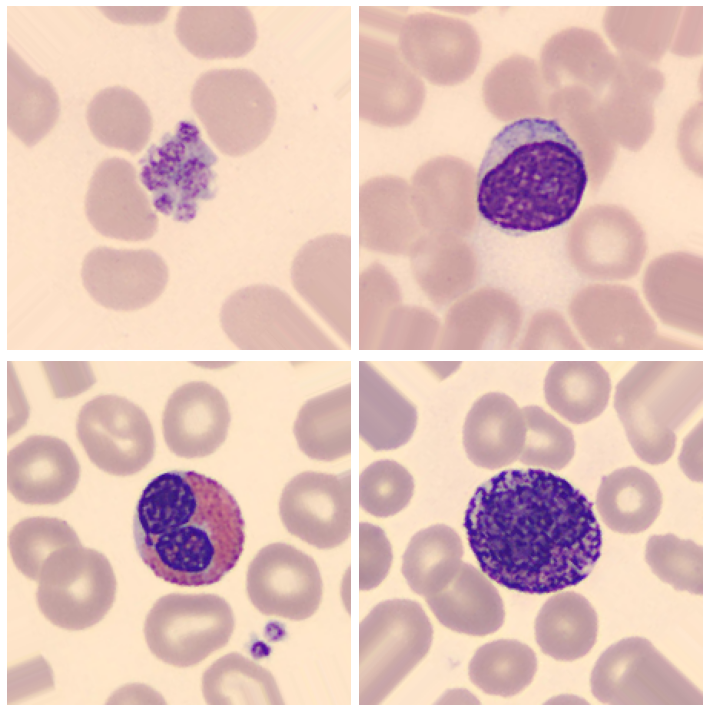

In [9]:
images = [training_set[0][0][i] for i in range(5)]
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMG_SIZE, IMG_SIZE, 3).astype('uint8'))
    ax.axis('off')

plt.tight_layout()
plt.show()

## ViT model set up

In [11]:
# classes = utils.get_imagenet_classes()

vit_model = vit.vit_b16(
    weights='imagenet21k+imagenet2012',
        image_size = IMG_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False, #fine tune
        classes = N_CLASSES)


347504640/347502902 [==============================] - 6s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


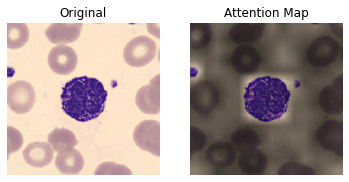

In [12]:
x = testing_set.next()
image = x[0][0]

attention_map = visualize.attention_map(model = vit_model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image.astype('uint8'))
_ = ax2.imshow(attention_map)

In [13]:
vit_model.summary()

Model: "vit-b16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 14, 14, 768)       590592    
_________________________________________________________________
reshape (Reshape)            (None, 196, 768)          0         
_________________________________________________________________
class_token (ClassToken)     (None, 197, 768)          768       
_________________________________________________________________
Transformer/posembed_input ( (None, 197, 768)          151296    
_________________________________________________________________
Transformer/encoderblock_0 ( ((None, 197, 768), (None, 7087872   
_________________________________________________________________
Transformer/encoderblock_1 ( ((None, 197, 768), (None, 7087

In [14]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Dense(256, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b16 (Functional)         (None, 768)               85798656  
_________________________________________________________________
dense (Dense)                (None, 256)               196864    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 11)                2827      
Total params: 85,999,371
Trainable params: 85,998,859
Non-trainable params: 512
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"


In [15]:
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LR)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

In [16]:
from datetime import datetime

t = datetime.now().strftime("%d%m%Y_%H")

path = Path(f'../working/model_save/vit_b16/{t}')
path.mkdir(parents=True, exist_ok=True)

In [17]:
# Callbacks


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = path/'model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks_list = [earlystopping, reduce_lr, checkpointer]

In [18]:
model.layers[0].trainable = False

for layer in model.layers:
    print(layer, layer.trainable)
    
model.summary()

<tensorflow.python.keras.engine.functional.Functional object at 0x7fb40c756b10> False
<tensorflow.python.keras.layers.core.Dense object at 0x7fb41e8f2890> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb41e933d10> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fb41e8f2f90> True
Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b16 (Functional)         (None, 768)               85798656  
_________________________________________________________________
dense (Dense)                (None, 256)               196864    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 11)                2827      
Total params: 85,999,371
Trainable params: 20

In [19]:

## Compute weights :
# class_weights = compute_weights(method = 3)

## Training :
epochs = 100
training_history = model.fit(x = training_set, 
                             steps_per_epoch = training_set.n/training_set.batch_size,
                             validation_steps = validation_set.n/validation_set.batch_size,

                             epochs = epochs,
                             callbacks = callbacks_list,
                             validation_data = validation_set, 
#                              class_weight = class_weights
                            )

model.save(path)

Epoch 1/100
395/395 [==============================] - 421s 924ms/step - loss: 2.4088 - accuracy: 0.3063 - val_loss: 1.6104 - val_accuracy: 0.6751

Epoch 00001: val_accuracy improved from -inf to 0.67514, saving model to ../working/model_save/vit_b16/18092021_15/model.hdf5
Epoch 2/100
395/395 [==============================] - 350s 883ms/step - loss: 1.5140 - accuracy: 0.6712 - val_loss: 1.4614 - val_accuracy: 0.7052

Epoch 00002: val_accuracy improved from 0.67514 to 0.70520, saving model to ../working/model_save/vit_b16/18092021_15/model.hdf5
Epoch 3/100
395/395 [==============================] - 349s 882ms/step - loss: 1.3718 - accuracy: 0.7460 - val_loss: 1.3573 - val_accuracy: 0.7607

Epoch 00003: val_accuracy improved from 0.70520 to 0.76069, saving model to ../working/model_save/vit_b16/18092021_15/model.hdf5
Epoch 4/100
395/395 [==============================] - 346s 873ms/step - loss: 1.3229 - accuracy: 0.7637 - val_loss: 1.3110 - val_accuracy: 0.7723

Epoch 00004: val_accurac

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"
/opt/conda/lib/python3.7/site-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"


In [20]:
import pickle

with open(path/'training_hist_b16', 'wb') as f:
    pickle.dump(training_history.history, f)

In [21]:
model.save(path/'model_vit_test')


/opt/conda/lib/python3.7/site-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"
/opt/conda/lib/python3.7/site-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"
/opt/conda/lib/python3.7/site-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"


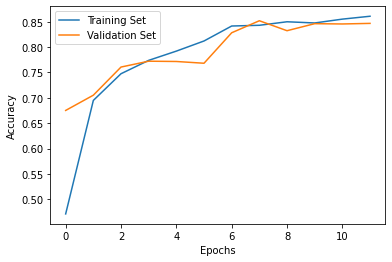

In [22]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(earlystopping.stopped_epoch), training_accuracy[0:earlystopping.stopped_epoch], label = 'Training Set')
plt.plot(np.arange(earlystopping.stopped_epoch), validation_accuracy[0:earlystopping.stopped_epoch], label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
model.evaluate(testing_set)


80/80 [==============================] - 25s 312ms/step - loss: 1.1593 - accuracy: 0.8608


[1.159317970275879, 0.8608490824699402]

In [24]:
model.evaluate(validation_set)

55/55 [==============================] - 15s 267ms/step - loss: 1.1633 - accuracy: 0.8520


[1.1633052825927734, 0.8520231246948242]

In [25]:
predictions = model.predict(validation_set)
y_pred = tf.argmax(predictions, axis = 1)

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

confusion_matrix(validation_set.classes, y_pred)

array([[ 9,  7, 23, 13,  6, 13, 11,  4, 20,  5, 15],
       [14, 17, 36, 12,  4, 10, 14, 10, 23,  0, 13],
       [35, 25, 62, 33, 18, 24, 28, 19, 42, 10, 40],
       [14, 13, 33, 14,  9,  7, 12, 11, 22,  4, 13],
       [12,  6, 16, 10,  6,  8, 11,  6, 17,  3,  7],
       [10, 22, 22, 11, 10,  7,  7,  8, 13,  4,  9],
       [18, 15, 27, 12, 12,  4,  7,  9, 22,  2, 18],
       [ 8, 10, 23, 11, 11,  8, 13,  3, 22,  2,  9],
       [16, 26, 55, 17, 11, 19, 28,  9, 33,  5, 27],
       [ 4,  8, 10,  4,  4,  2,  9,  1,  7,  1,  5],
       [15, 19, 30, 12,  9, 15, 17,  5, 23,  4, 22]])

In [27]:
list(validation_set.class_indices.keys())  

['BA', 'BNE', 'EO', 'ERB', 'LY', 'MMY', 'MO', 'MY', 'PLT', 'PMY', 'SNE']

<AxesSubplot:>

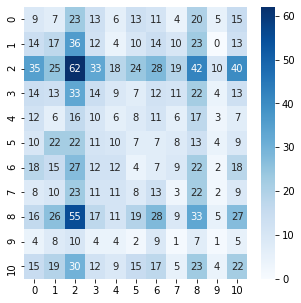

In [28]:
import seaborn as sns
# true_classes = validation_set.classes
# class_labels = list(validation_set.class_indices.keys())  

# confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (5, 5))
sns.heatmap(confusion_matrix(validation_set.classes, y_pred), cmap = 'Blues', annot = True, cbar = True)

# print(classification_report(true_classes, predicted_classespredictions

In [29]:
predicted_classes = np.argmax(model.predict(validation_set,
                                            steps = validation_set.n // validation_set.batch_size + 1), 
                              axis = 1)